# Vision Transformers

In this notebook, we will define and implement the Vision Transformer model.


Just as transformers-based models have revolutionized NLP, we're now seeing an explosion of papers applying them to all sorts of other domains. One of the most revolutionary of these was the Vision Transformer (ViT), which was introduced in June 2021 by a team of researchers at Google Brain.

[An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

## Vision Transformer
![vit_figure.png](https://raw.githubusercontent.com/google-research/vision_transformer/main/vit_figure.png)


>Inspired by the Transformer scaling successes in NLP, we experiment with applying a standard Transformer directly to images, with the fewest possible modifications. To do so, **we split an image into patches and provide the sequence of linear embeddings of these patches as an input to a Transformer**. Image patches are treated the same way as tokens (words) in an NLP application. We train the model on image classification in supervised fashion.  <br><sub>1 Introduction<sub>
    
>In model design we follow the original Transformer as closely as possible. An advantage of this intentionally simple setup is that scalable NLP Transformer architectures – and their efficient implementations – can be used almost out of the box. <br><sub>3 Method<sub>


## Model Configuration

<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/vit_input.png?raw=true'>


<img src='https://aman.ai/primers/ai/assets/vit/source.gif'>

We will walkthrough the components of Vision Transformer:
1. Split Image into Patches  
The input image is split into 14 x 14 vectors with dimension of 768 by Conv2d (k=16x16) with stride=(16, 16).
2. Add Position Embeddings  
Learnable position embedding vectors are added to the patch embedding vectors and fed to the transformer encoder.
3. Transformer Encoder  
The embedding vectors are encoded by the transformer encoder. The dimension of input and output vectors are the same. Details of the encoder are depicted in Fig. 2.
4. MLP (Classification) Head  
The 0th output from the encoder is fed to the MLP head for classification to output the final classification results.

## 1. Image To Patches

Image patches are basically the sequence tokens (like words). In fact, the encoder block is identical to the original transformer proposed by Vaswani et al. (2017) as we have extensively described.


In [3]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=05a6c08c3f33fab8c2cd57904ddc62be92e83a8ffb432ffffec4cfb024bfa284
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [4]:
!wget https://www.korea.net/upload/fileShare/2022/10/usr_1665723049887.jpg

--2025-02-11 07:39:04--  https://www.korea.net/upload/fileShare/2022/10/usr_1665723049887.jpg
Resolving www.korea.net (www.korea.net)... 108.156.144.94, 108.156.144.16, 108.156.144.24, ...
Connecting to www.korea.net (www.korea.net)|108.156.144.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38674 (38K) [image/jpeg]
Saving to: ‘usr_1665723049887.jpg’

usr_1665723049887.j 100%[===================>]  37.77K  --.-KB/s    in 0.002s  

2025-02-11 07:39:04 (22.5 MB/s) - ‘usr_1665723049887.jpg’ saved [38674/38674]



### Let's patch the image!

In [5]:
# unit test on patching an image
image = # TODO: read image and resize to 128

# convert to numpy array
x = np.array(image)

# An Image Is Worth 16x16 Words
P = 16   # patch size
C = 3    # number of channels (RGB)

# reshape: 세로 방향을 16 픽셀 단위로 쪼갬, 가로방향을 16 픽셀 단위로 쪼갬
# 각 patch의 너비=16
# 채널수 유의
patches = # TODO:split image into patches using numpy

# flatten patches
x_p = np.reshape(patches, (-1, P * P * C))

# get number of patches
N = x_p.shape[0]

print('Image shape: ', x.shape)  # width, height, channel
print('Number of patches: {} with resolution ({}, {})'.format(N, P, P))
print('Patches shape: ', patches.shape)
print('Flattened patches shape: ', x_p.shape)

Image shape:  (128, 128, 3)
Number of patches: 64 with resolution (16, 16)
Patches shape:  (64, 16, 16, 3)
Flattened patches shape:  (64, 768)


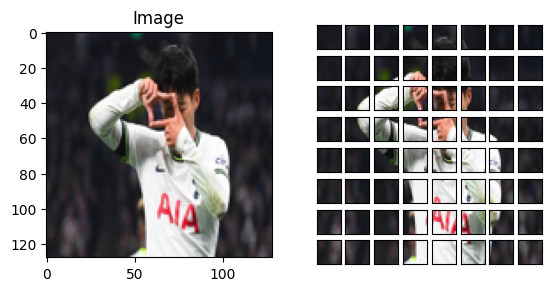

In [6]:
# visualize data
# display image and patches side-by-side

fig = plt.figure()

gridspec = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gridspec[0])
ax1.set(title='Image')

# display image
ax1.imshow(x)

subgridspec = gridspec[1].subgridspec(8, 8, hspace=-0.8)

# display patches
for i in range(8):    # N = 64, 8x8 grid
    for j in range(8):
        num = i * 8 + j
        ax = fig.add_subplot(subgridspec[i, j])
        ax.set(xticks=[], yticks=[])
        ax.imshow(patches[num])

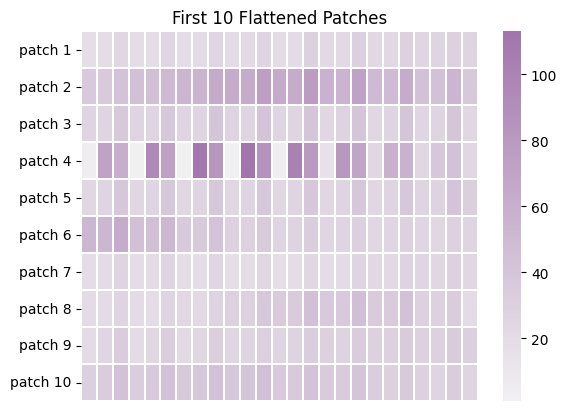

In [7]:
# visualize data
# display flattened patches
# display first 10 flattened patches up to 25 values
heat_map = x_p[:10, :25]

yticklabels = ['patch ' + str(i + 1) for i in range(10)]

plt.title('First 10 Flattened Patches')
ax = sns.heatmap(heat_map,
                 cmap=sns.light_palette("#a275ac", as_cmap=True),
                 xticklabels=False, yticklabels=yticklabels,
                 linewidths=0.01, linecolor='white'
                )


## Embedding Patches


>The Transformer uses constant latent vector size D through all of its layers, so we flatten the patches and map to D dimensions with a trainable linear projection. We refer to the output of this projection as the **patch embeddings**. <br><sub>3.1 Vision Transformer (ViT)<sub>

In [8]:
# unit test on patch embeddings
# dimensionality of patch embeddings
D = 768

# batch size
B = 1

# convert flattened patches to tensor
x_p = torch.Tensor(x_p)

# add batch dimension
x_p = x_p[None, ...]

# weight matrix E
E = # TODO: 선형 변환을 위한 weight matrix E 생성

patch_embeddings = # TODO: Patch embedding 계산,
# (batch_size, num_patches, patch_dim) → (batch_size, num_patches, embedding_dim)

assert patch_embeddings.shape == (B, N, D)
print(patch_embeddings.shape)

torch.Size([1, 64, 768])


## Class Token


>In order to perform classification, we use the standard approach of adding an extra learnable “classification token” to the sequence. <br><sub>Model Overview<sub>

>Similar to BERT’s [class] token, we prepend a learnable embedding to the sequence of embedded patches (xclass). <br><sub>3.1 Vision Transformer (ViT)<sub>

In [9]:
# unit test on class token

# init class token
class_token = nn.Parameter(torch.randn(1, 1, D))

patch_embeddings = # TODO: class token 과 patch embedding 결합

print(patch_embeddings.shape)
assert patch_embeddings.shape == (B, N + 1, D)

torch.Size([1, 65, 768])


## Position Embedding

>Position embeddings are added to the patch embeddings to **retain positional information**. We use standard learnable 1D position embeddings. <br><sub>3.1 Vision Transformer (ViT)<sub>

In [10]:
# unit test on position embedddings
# position embeddings
# 패치 순서 정보를 Transformer에 제공.
E_pos = # TODO: positional embedding 정의
z0 = patch_embeddings + E_pos

print(z0.shape)
assert z0.shape == (B, N + 1, D)

torch.Size([1, 65, 768])


## Self-Attention
Self-Attention은 Transformer의 핵심 연산으로, 패치(토큰) 간의 관계를 학습하는 과정입니다.
이 코드는 Scaled Dot-Product Attention을 구현하고, ViT에서 입력된 패치 임베딩에 적용하는 과정입니다.

In [11]:
class SelfAttention(nn.Module):
    def __init__(self, embedding_dim=768, key_dim=64):
        super(SelfAttention, self).__init__()

        self.embedding_dim = embedding_dim   # D -> embedding dimensionaltiy
        self.key_dim = key_dim               # D_h -> key, query, value dimensionality

        # U_kqv weight matrix
        self.W = nn.Parameter(torch.randn(embedding_dim, 3*key_dim))

    def forward(self, x):
        key_dim = self.key_dim

        # get query, key and value projection
        qkv = torch.matmul(x, self.W)

        # get query, key, value
        q = qkv[:, :, :key_dim]
        k = qkv[:, :, key_dim:key_dim*2 ]
        v = qkv[:, :, key_dim*2:]

        # compute dot product of the all query with all keys
        k_T = torch.transpose(k, -2, -1)   # get transpose of key
        dot_products = torch.matmul(q, k_T)

        # divide each by √Dh
        scaled_dot_products = dot_products / np.sqrt(key_dim)

        # apply a softmax function to obtain attention weights -> A
        attention_weights = F.softmax(scaled_dot_products, dim=1)
        # self.attention_weights = [w.detach().numpy() for w in attention_weights]

        # get weighted values
        weighted_values = torch.matmul(attention_weights, v)

        # return weighted_values
        return weighted_values

In [12]:
# unit test on self-attention

# dimensionality of key, query and value
D_h = 64

# init self-attention
self_attention = SelfAttention(D, D_h)   # embedding_dim, key_dim

attention_scores = self_attention(patch_embeddings)

print(attention_scores.shape)
assert attention_scores.shape == (B, N + 1, D_h)

torch.Size([1, 65, 64])


## Multi-Head Self-Attention


In [13]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12):
        super(MultiHeadSelfAttention, self).__init__()

        self.num_heads = num_heads            # set number of heads (k)
        self.embedding_dim = embedding_dim    # set dimensionality

        assert embedding_dim % num_heads == 0   # dimensionality should be divisible by number of heads
        self.key_dim = embedding_dim // n_head   # set key,query and value dimensionality

        # init self-attentions
        self.attention_list = [SelfAttention(embedding_dim, self.key_dim) for _ in range(num_heads)]
        self.multi_head_attention = nn.ModuleList(self.attention_list)

        # init U_msa weight matrix
        self.W = nn.Parameter(torch.randn(num_heads * self.key_dim, embedding_dim))

    def forward(self, x):
        # compute self-attention scores of each head
        attention_scores = [attention(x) for attention in self.multi_head_attention]

        # concat attentions
        Z = torch.cat(attention_scores, -1)

        # compute multi-head attention score
        attention_score = torch.matmul(Z, self.W)

        return attention_score


In [14]:
# unit test on multi-head self-attention

# number of heads (k)
n_head = 12

multi_head_attention = # TODO: init multi-head self-attention
attention_score = # TODO: compute MSA score

print(attention_score.shape)
assert attention_score.shape == (B, N + 1, D)

torch.Size([1, 65, 768])


## Multi-Layer Perceptron

>The MLP contains two layers with a GELU non-linearity. <br><sub>3.1 Vision Transformer (ViT)<sub>

- Why MLP? Self-Attention은 선형 연산이므로, 비선형성을 추가해야 모델이 더 강력한 특징을 학습 가능.
- GELU(Gaussian Error Linear Unit)를 사용하는 이유: 일반적인 활성화 함수인 ReLU보다 부드러운 비선형성을 제공.

In [15]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, embedding_dim=768, hidden_dim=3072):
        super(MultiLayerPerceptron, self).__init__()

        self.mlp = nn.Sequential(
                            nn.Linear(embedding_dim, hidden_dim),
                            nn.GELU(),
                            nn.Linear(hidden_dim, embedding_dim)
                   )

    def forward(self, x):
        # pass through multi-layer perceptron
        x = self.mlp(x)
        return x

In [16]:
# unit test on multi-layer perceptron

# hidden layer dimensionality
hidden_dim = 3072

mlp = # TODO: init mlp
output = # TODO: compute mlp output

assert output.shape == (B, N + 1, D)
output.shape

torch.Size([1, 65, 768])

## Transformer Encoder


>The Transformer encoder consists of alternating layers of multiheaded self-attention (MSA) and MLP blocks. Layernorm (LN) is applied before every block, and residual connections after every block. <br><sub>3.1 Vision Transformer (ViT)<sub>

In [17]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12, hidden_dim=3072, dropout_prob=0.1):
        super(TransformerEncoder, self).__init__()

        self.MSA = MultiHeadSelfAttention(embedding_dim, num_heads)
        self.MLP = MultiLayerPerceptron(embedding_dim, hidden_dim)

        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.dropout3 = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        # apply dropout
        out_1 = self.dropout1(x)
        # apply layer normalization
        out_2 = self.layer_norm1(out_1)
        # compute multi-head self-attention
        msa_out = self.MSA(out_2)
        # apply dropout
        out_3 = self.dropout2(msa_out)
        # apply residual connection
        res_out = x + out_3
        # apply layer normalization
        out_4 = self.layer_norm2(res_out)
        # compute mlp output
        mlp_out = self.MLP(out_4)
        # apply dropout
        out_5 = self.dropout3(mlp_out)
        # apply residual connection
        output = res_out + out_5

        return output

In [18]:
# unit test on transformer encoder

# dropout probability
dropout_prob = 0.1

transformer_encoder = # TODO: init transformer encoder
output = # TODO: compute transformer encoder output

assert output.shape == (B, N + 1, D)
output.shape

torch.Size([1, 65, 768])

>We found strong regularization to be key when training models from scratch on ImageNet. Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional to patch embeddings. <br><sub>B.1 Training<sub>

## MLP Head



>The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time. <br><sub>3.1 Vision Transformer (ViT)<sub>

> In order to stay as close as possible to the original Transformer model, we made use of an additional [class] token, which is taken as image representation. The output of this token is then transformed into a class prediction via a small multi-layer perceptron (MLP) with tanh as non-linearity in the single hidden layer. <br><sub>D.3 Head Type and Class Token<sub>

- ViT에서 최종적으로 분류 작업을 수행하기 위해 MLP Head(분류기)를 사용합니다.
이 코드는 Transformer Encoder에서 나온 CLS 토큰을 받아 최종 클래스를 예측하는 과정을 보여줍니다.
Pre-training과 Fine-tuning 단계에서 서로 다른 구조의 MLP를 사용하는 특징이 있음.

In [19]:
class MLPHead(nn.Module):
    def __init__(self, embedding_dim=768, num_classes=10, fine_tune=False):
        super(MLPHead, self).__init__()
        self.num_classes = num_classes

        if not fine_tune:
            # hidden layer with tanh activation function
            self.mlp_head = nn.Sequential(
                                    nn.Linear(embedding_dim, 3072),  # hidden layer
                                    nn.Tanh(),
                                    nn.Linear(3072, num_classes)    # output layer
                            )
        else:
            # single linear layer
            self.mlp_head = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = self.mlp_head(x)
        return x


In [20]:
# unit test on classification head

z_L = # TODO: extract [class] token from transformer encoder output. extract batch and [class] token

# init number of classes
n_class = 10
mlp_head_pretrain = # TODO:  init classification head for pre-training phase
mlp_head_finetune = # TODO: init classification head for fine-tuning phase

output_1 = # TODO: compute mlp head output
output_2 = # TODO: compute mlp head output for fine-tuning


# size of output
print(output_1.size(dim=0))

# assert output is consistent with number of classes
assert output_1.size(dim=0) == n_class
assert output_2.size(dim=0) == n_class

10


## Vision Transformer


>We split an image into fixed-size patches, linearly embed each of them, add position embeddings, and feed the resulting sequence of vectors to a standard Transformer encoder. <br><sub>Model Overview<sub>

> The output of the Transformer encoder (zL0) serves as the image representation y. Both during pre-training and fine-tuning, a classification head is attached to zL0. <br><sub>3.1 Vision Transformer (ViT)<sub>


In [21]:
class VisionTransformer(nn.Module):
    def __init__(self, patch_size=16, image_size=224, channel_size=3,
                     num_layers=12, embedding_dim=768, num_heads=12, hidden_dim=3072,
                            dropout_prob=0.1, num_classes=10, pretrain=True):
        super(VisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.channel_size = channel_size
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.dropout_prob = dropout_prob
        self.num_classes = num_classes

        # get number of patches of the image
        self.num_patches = int(image_size ** 2 / patch_size ** 2)   # height * width / patch size ^ 2

        # trainable linear projection for mapping dimnesion of patches (weight matrix E)
        self.W = nn.Parameter(
                    torch.randn( patch_size * patch_size * channel_size, embedding_dim))

        # position embeddings (E_pos)
        self.pos_embedding = nn.Parameter(torch.randn(self.num_patches + 1, embedding_dim))

        # learnable class token embedding (x_class)
        self.class_token = nn.Parameter(torch.rand(1, D))

        # stack transformer encoder layers
        transformer_encoder_list = [
            TransformerEncoder(embedding_dim, num_heads, hidden_dim, dropout_prob)
                    for _ in range(num_layers)]
        self.transformer_encoder_layers = nn.Sequential(*transformer_encoder_list)

        # mlp head
        self.mlp_head = MLPHead(embedding_dim, num_classes)

    def forward(self, x):
        # get patch size and channel size
        P, C = self.patch_size, self.channel_size

        # split image into patches
        patches = x.unfold(1, C, C).unfold(2, P, P).unfold(3, P, P)
        patches = patches.contiguous().view(patches.size(0), -1, C * P * P).float()

        # linearly embed patches
        patch_embeddings = torch.matmul(patches , self.W)

        # add class token
        batch_size = patch_embeddings.shape[0]
        patch_embeddings = torch.cat((self.class_token.repeat(batch_size, 1, 1), patch_embeddings), 1)

        # add positional embedding
        patch_embeddings = patch_embeddings + self.pos_embedding

        # feed patch embeddings into a stack of Transformer encoders
        transformer_encoder_output = self.transformer_encoder_layers(patch_embeddings)

        # extract [class] token from encoder output
        output_class_token = transformer_encoder_output[:, 0]

        # pass token through mlp head for classification
        y = self.mlp_head(output_class_token)

        return y

In [22]:

# unit test on vision transformer

image_size = 224; channel_size = 3

# number of classes CIFAR-10
n_class = 10

# dropout probability
dropout_prob = 0.1

# Vit-base model configurations
n_layer = 12; embedding_dim = 768; n_head = 12; hidden_dim=3072

# read and resize image
image = Image.open('/content/usr_1665723049887.jpg').resize((image_size, image_size))

# convert PIL image to tensor
X = T.PILToTensor()(image)

# add batch dimension
X =  X[None, ...]    # batch size = 1

# An Image Is Worth 16x16 Words
patch_size = 16

# init vision transformer model
vision_transformer = VisionTransformer(patch_size, image_size, channel_size,
                            n_layer, embedding_dim, n_head, hidden_dim, dropout_prob, n_class)

# compute vision transformer output
vit_output = vision_transformer(X)

assert vit_output.size(dim=1) == n_class
print(vit_output.shape)

# get class probabilities
probabilities = F.softmax(vit_output[0], dim=0)

# probabilities should sum up to 1
print(torch.sum(probabilities))

torch.Size([1, 10])
tensor(1.0000, grad_fn=<SumBackward0>)


## Training Vision Transformer

We initially seek to have a look at how transformer performs by training the model. However, we are not able to use the configurations that are set for training in the paper since we do not have enough resources (single GPU with 4 GB CUDA memory :)). Instead, we use different set of hyperparameters for batch size, learning rate, etc. to see the model performance. <br><br>

After several failing attempts and discouraging results, we decide not to train the model implemented here from scratch. To see how vision transformer models perform, we will use the pytorch [Vision Transformer](https://pytorch.org/vision/main/models/vision_transformer.html) with pretrained weights using [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

>We train all models, including ResNets, using Adam with β1 = 0.9, β2 = 0.999, a batch size of 4096 and apply a high weight decay of 0.1, which we found to be useful for transfer of all models. <br><sub>4.1 Setup **Training & Fine-tuning**<sub>
   
>To boost the performance on the smaller datasets, we optimize three basic regularization parameters – weight decay, dropout, and label smoothing. <br><sub>4.3 Pre-Training Data Requirement<sub>

In [23]:
import torchvision
from torchvision import datasets

In [24]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [25]:
import torchvision.models as models

In [26]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [27]:
# Load data
#
# We will use a subset of CIFAR10 dataset

image_size = 224

# define transform
transform = T.Compose([ T.Resize(image_size), T.ToTensor() ])

torchvision.datasets.CIFAR10.url="http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

# init CIFAR10 training and test datasets
trainset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

# get class names
classes = trainset.classes

# get a subset of the trainset and test set
trainset = torch.utils.data.Subset(trainset, list(range(5000)))
testset = torch.utils.data.Subset(testset, list(range(1000)))

# output classes
classes

100%|██████████| 170M/170M [00:18<00:00, 9.08MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [28]:
# define data loaders

batch_size = 16

# percentage of training set to use as validation
valid_size = 0.2

# get training indices that wil be used for validation
train_size = len(trainset)
indices = list(range(train_size))
np.random.shuffle(indices)
split = int(np.floor(valid_size * train_size))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers to obtain training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(testset, batch_size=batch_size)

In [29]:
# print out classes statistics

# get all training samples labels
train_labels = [labels for i, (images, labels) in enumerate(train_loader)]
train_labels = torch.cat((train_labels), 0)
train_labels_count = train_labels.unique(return_counts=True)

# print(train_labels_count)

print('The number of samples per classes in training dataset:\n')
for label, count in zip(train_labels_count[0], train_labels_count[1]):
    print('\t {}: {}'.format(label, count))

# get all test samples labels
test_labels = [labels for i, (images, labels) in enumerate(test_loader)]
test_labels = torch.cat((test_labels), 0)
test_labels_count = test_labels.unique(return_counts=True)

print()
print('The number of samples per classes in test dataset:\n')
for label, count in zip(test_labels_count[0], test_labels_count[1]):
    print('\t {}: {}'.format(label, count))

The number of samples per classes in training dataset:

	 0: 392
	 1: 379
	 2: 405
	 3: 381
	 4: 413
	 5: 395
	 6: 420
	 7: 390
	 8: 415
	 9: 410

The number of samples per classes in test dataset:

	 0: 103
	 1: 89
	 2: 100
	 3: 103
	 4: 90
	 5: 86
	 6: 112
	 7: 102
	 8: 106
	 9: 109


In [30]:
# define model

vision_transformer = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)

vision_transformer

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 175MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [31]:
# vit-16 model is trained on ImageNet
# we expect to have output of 1000 number of classes

vision_transformer.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [32]:
# fine-tune with dataset

# change the number of output classes
vision_transformer.heads = nn.Linear(in_features=768, out_features=len(classes), bias=True)

# freeze the parameters except the last linear layer
#
# freeze weights
for p in vision_transformer.parameters():
    p.requires_grad = False

# unfreeze weights of classification head to train
for p in vision_transformer.heads.parameters():
    p.requires_grad = True

In [33]:
# check whether corresponding layers are frozen

for layer_name, p in vision_transformer.named_parameters():
    print('Layer Name: {}, Frozen: {}'.format(layer_name, not p.requires_grad))
    print()

Layer Name: class_token, Frozen: True

Layer Name: conv_proj.weight, Frozen: True

Layer Name: conv_proj.bias, Frozen: True

Layer Name: encoder.pos_embedding, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_1.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.in_proj_bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.self_attention.out_proj.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.ln_2.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.mlp.0.weight, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.mlp.0.bias, Frozen: True

Layer Name: encoder.layers.encoder_layer_0.mlp.3.weight, Fro

In [34]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# define optimizer
# only train the parameters with requires_grad set to True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vision_transformer.parameters()), lr=0.0001)


In [35]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
train_on_gpu

True

In [36]:
# load model if it exists
import os

model_path = 'vit.pth'

if os.path.exists(model_path):
    vision_transformer.load_state_dict(torch.load(model_path))

In [39]:
from tqdm.auto import tqdm

In [40]:
# Train model

# number of epochs
n_epoch = 5

# number of iterations to save model
n_step=100

train_loss_list, valid_loss_list = [], []

# move model to GPU
if train_on_gpu:
    vision_transformer.to('cuda')

# prepare model for training
vision_transformer.train()

for e in range(n_epoch):
    train_loss = 0.0
    valid_loss = 0.0

    # get batch data
    for i, (images, targets) in tqdm(enumerate(train_loader)):

        # move to gpu if available
        if train_on_gpu:
            images, targets = images.to('cuda'), targets.to('cuda')

        # clear grad
        optimizer.zero_grad()

        # feedforward data
        outputs = vision_transformer(images)

        # calculate loss
        loss = criterion(outputs, targets)

        # backward pass, calculate gradients
        loss.backward()

        # update weights
        optimizer.step()

        # track loss
        train_loss += loss.item()

        # save the model parameters
        if i % n_step == 0:
            torch.save(vision_transformer.state_dict(), model_path)

    # set model to evaluation mode
    vision_transformer.eval()

    # validate model
    for images, targets in valid_loader:

        # move to gpu if available
        if train_on_gpu:
            images = images.to('cuda')
            targets = targets.to('cuda')

        # turn off gradients
        with torch.no_grad():

            outputs = vision_transformer(images)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

    # set model back to trianing mode
    vision_transformer.train()

    # get average loss values
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)

    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # output training statistics for epoch
    print('Epoch: {} \t Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                  .format( (e+1), train_loss, valid_loss))



0it [00:00, ?it/s]

Epoch: 1 	 Training Loss: 1.198560 	 Validation Loss: 0.917684


0it [00:00, ?it/s]

Epoch: 2 	 Training Loss: 0.768643 	 Validation Loss: 0.677442


0it [00:00, ?it/s]

Epoch: 3 	 Training Loss: 0.596653 	 Validation Loss: 0.563388


0it [00:00, ?it/s]

Epoch: 4 	 Training Loss: 0.506138 	 Validation Loss: 0.502648


0it [00:00, ?it/s]

Epoch: 5 	 Training Loss: 0.449459 	 Validation Loss: 0.458655


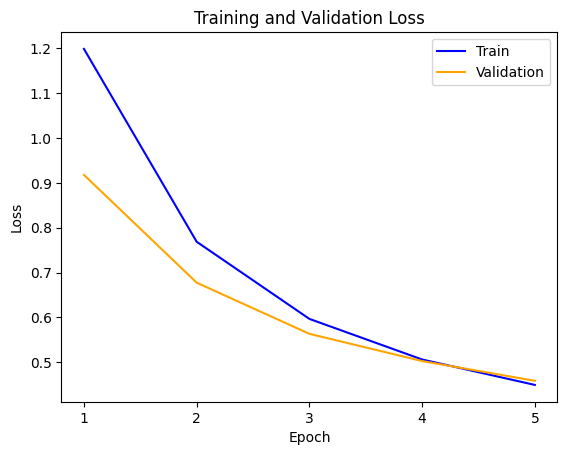

In [41]:
# visualize loss statistics

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# plot losses
x = list(range(1, n_epoch + 1))
plt.plot(x, train_loss_list, color ="blue", label='Train')
plt.plot(x, valid_loss_list, color="orange", label='Validation')
plt.legend(loc="upper right")
plt.xticks(x)

plt.show()

In [43]:
# prepare model for evaluation
vision_transformer.eval()

test_loss = 0.0
accuracy = 0

# number of classes
n_class = len(classes)

class_correct = np.zeros(n_class)
class_total = np.zeros(n_class)

# move model back to cpu
vision_transformer = vision_transformer.to('cpu')

# test model
for images, targets in tqdm(test_loader):

    # get outputs
    outputs = vision_transformer(images)

    # calculate loss
    loss = criterion(outputs, targets)

    # track loss
    test_loss += loss.item()

    # get predictions from probabilities
    preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

    # get correct predictions
    correct_preds = (preds == targets).type(torch.FloatTensor)

    # calculate and accumulate accuracy
    accuracy += torch.mean(correct_preds).item() * 100

    # calculate test accuracy for each class
    for c in range(n_class):

        class_total[c] += (targets == c).sum()
        class_correct[c] += ((correct_preds) * (targets == c)).sum()

# get average accuracy
accuracy = accuracy / len(test_loader)

# get average loss
test_loss = test_loss / len(test_loader)

# output test loss statistics
print('Test Loss: {:.6f}'.format(test_loss))


  0%|          | 0/63 [00:00<?, ?it/s]

Test Loss: 0.431234


In [44]:
class_accuracy = class_correct / class_total

print('Test Accuracy of Classes')
print()

for c in range(n_class):
    print('{}\t: {}% \t ({}/{})'.format(classes[c],
                                int(class_accuracy[c] * 100), int(class_correct[c]), int(class_total[c])) )

print()
print('Test Accuracy of Dataset: \t {}% \t ({}/{})'.format(int(accuracy),
                                                           int(np.sum(class_correct)), int(np.sum(class_total)) ))

Test Accuracy of Classes

airplane	: 84% 	 (87/103)
automobile	: 92% 	 (82/89)
bird	: 80% 	 (80/100)
cat	: 86% 	 (89/103)
deer	: 91% 	 (82/90)
dog	: 88% 	 (76/86)
frog	: 89% 	 (100/112)
horse	: 90% 	 (92/102)
ship	: 96% 	 (102/106)
truck	: 89% 	 (98/109)

Test Accuracy of Dataset: 	 88% 	 (888/1000)


---
**Key, Value and Query**

The key/value/query concept is analogous to retrieval systems. For example, when we search for videos on Youtube, the search engine will map our query (text in the search bar) against a set of keys (video title, description, etc.) associated with candidate videos in their database, then present us the best matched videos (values). The dot product can be considered as defining some similarity between the text in search bar (query) and titles in the database (key).

---
**Vision Transformer Success**

>Our Vision Transformer (ViT) attains excellent results when pre-trained at sufficient scale and transferred to tasks with fewer datapoints. When pre-trained on the public ImageNet-21k dataset or the in-house JFT-300M dataset, ViT approaches or beats state of the art on multiple image recognition benchmarks. In particular, the best model reaches the accuracy of 88.55% on ImageNet, 90.72% on ImageNet-ReaL, 94.55% on CIFAR-100, and 77.63% on the VTAB suite of 19 tasks. <br><sub>1 Introduction<sub>


**Vision Transformer Weakness**

>Transformers lack some of the inductive biases inherent to CNNs, such as translation equivariance and locality, and therefore do not generalize well when trained on insufficient amounts of data. <br><sub>1 Introduction<sub>

>**Inductive bias**: We note that Vision Transformer has much less image-specific inductive bias than CNNs. In CNNs, locality, two-dimensional neighborhood structure, and translation equivariance are baked into each layer throughout the whole model. In ViT, only MLP layers are local and translationally equivariant, while the self-attention layers are global. The two-dimensional neighborhood structure is used very sparingly: in the beginning of the model by cutting the image into patches and at fine-tuning time for adjusting the position embeddings for images of different resolution. Other than that, the position embeddings at initialization time carry no information about the 2D positions of the patches and all spatial relations between the patches have to be learned from scratch. <br><sub>3.1 Vision Transformer (ViT)<sub>

---

**Final Notes**

The implementation here is a very basic representation of how Vision Transformers work. The code structure here is to preserve the simplicity of the code so that to be easier to follow. There are a lot of improvements that can be made in the implementation and calculations can be further optimized.

---

### Resources

1.  An Image is Worth 16x16 Words: Transformers For Image Recognition At Scale Paper - https://arxiv.org/pdf/2010.11929.pdf
2. Illustrated Transformer Blog Post - https://jalammar.github.io/illustrated-transformer/
3. Attention is All You Need Paper - https://arxiv.org/pdf/1706.03762.pdf
4. What exactly are keys, queries, and values in attention mechanisms? - https://stats.stackexchange.com/questions/421935/what-exactly-are-keys-queries-and-values-in-attention-mechanisms